# Air Pollution: Exploratory Data Analysis (EDA)

In this notebook we will explore the air pollution training data for our joint machine learning project. 

Source: [ZINDI](https://zindi.africa/competitions/zindiweekendz-learning-urban-air-pollution-challenge/data)

<blockquote> 
The objective of this challenge is to predict PM2.5 particulate matter concentration in the air every day for each city. 

```PM2.5``` refers to atmospheric particulate matter that have a diameter of less than 2.5 micrometers and is one of the most harmful air pollutants. ```PM2.5``` is a common measure of air quality that normally requires ground-based sensors to measure. The data covers the last three months, spanning hundreds of cities across the globe.

The data comes from three main sources:

- Ground-based air quality sensors. These measure the target variable (PM2.5 particle concentration). In addition to the target column (which is the daily mean concentration) there are also columns for minimum and maximum readings on that day, the variance of the readings and the total number (count) of sensor readings used to compute the target value. This data is only provided for the train set - you must predict the target variable for the test set.

- The Global Forecast System (GFS) for weather data. Humidity, temperature and wind speed, which can be used as inputs for your model.

- The Sentinel 5P satellite. This satellite monitors various pollutants in the atmosphere. For each pollutant, we queried the offline Level 3 (L3) datasets available in Google Earth Engine (you can read more about the individual products here: https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p). For a given pollutant, for example NO2, we provide all data from the Sentinel 5P dataset for that pollutant. This includes the key measurements like NO2_column_number_density (a measure of NO2 concentration) as well as metadata like the satellite altitude. We recommend that you focus on the key measurements, either the column_number_density or the tropospheric_X_column_number_density (which measures density closer to Earth’s surface).

Unfortunately, this data is not 100% complete. Some locations have no sensor readings for a particular day, and so those rows have been excluded. There are also gaps in the input data, particularly the satellite data for CH4.

</blockquote>

## Set up 

In [145]:
# Import packages

# basics
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_palette('magma')


# warnings
import warnings
warnings.filterwarnings('ignore')


## Load data

In [2]:
# load training data
df = pd.read_csv('data/Train.csv')

## Explore data frame

In [3]:
df.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df.shape

(30557, 82)

# Missing data
Let's explore the amount of missing data for all of our features. 

In [ ]:
! pip install missingno
import missingno as msno

<Axes: >

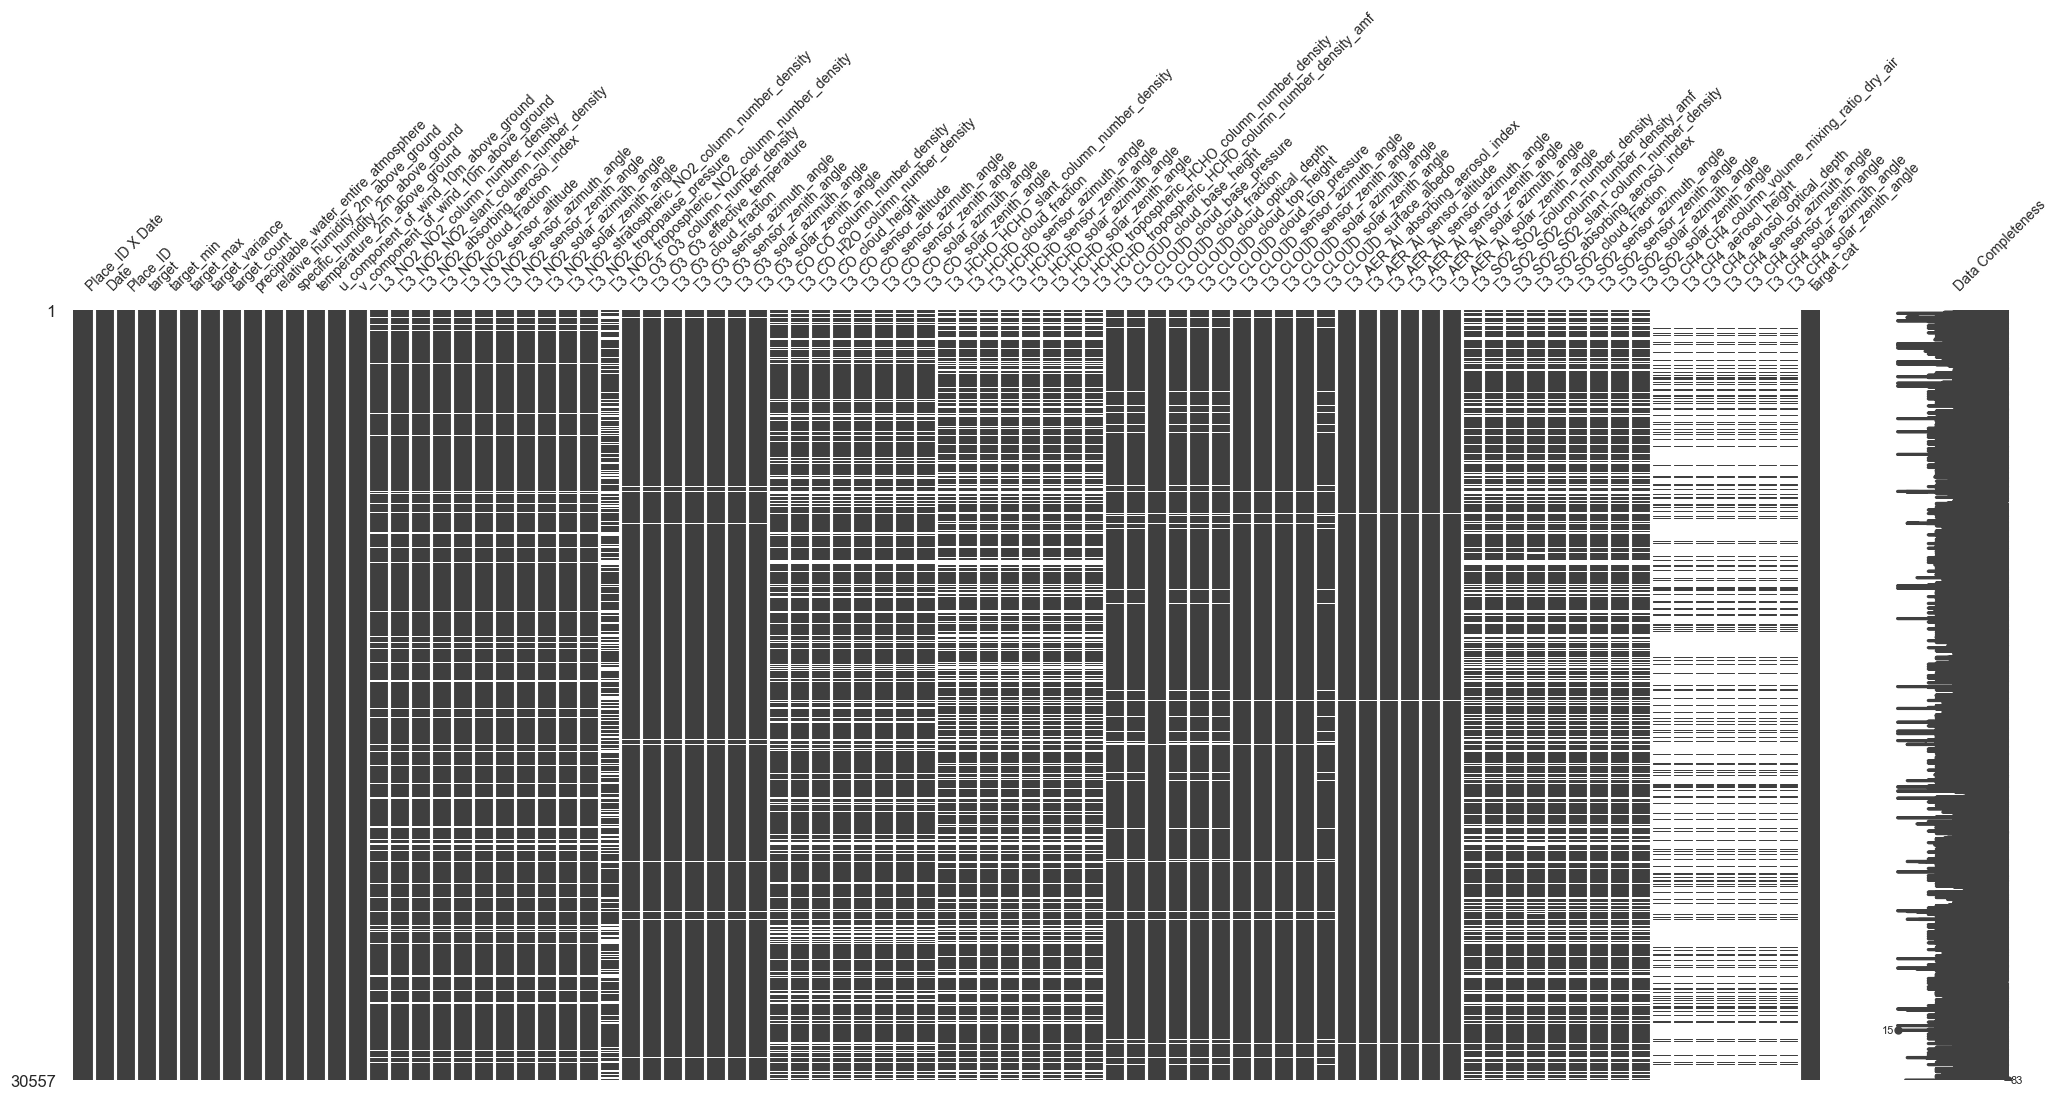

In [146]:
msno.matrix(df, fontsize=10,labels=True)

From the missingno matrix figure, it is clear that there is only missing data for the satellite data, not for the target or close-to-the-ground measurements. The amount of missing satellite data (```L3```) is clearly related to the pollutant, with only very sparse methane (```CHO4```) data.

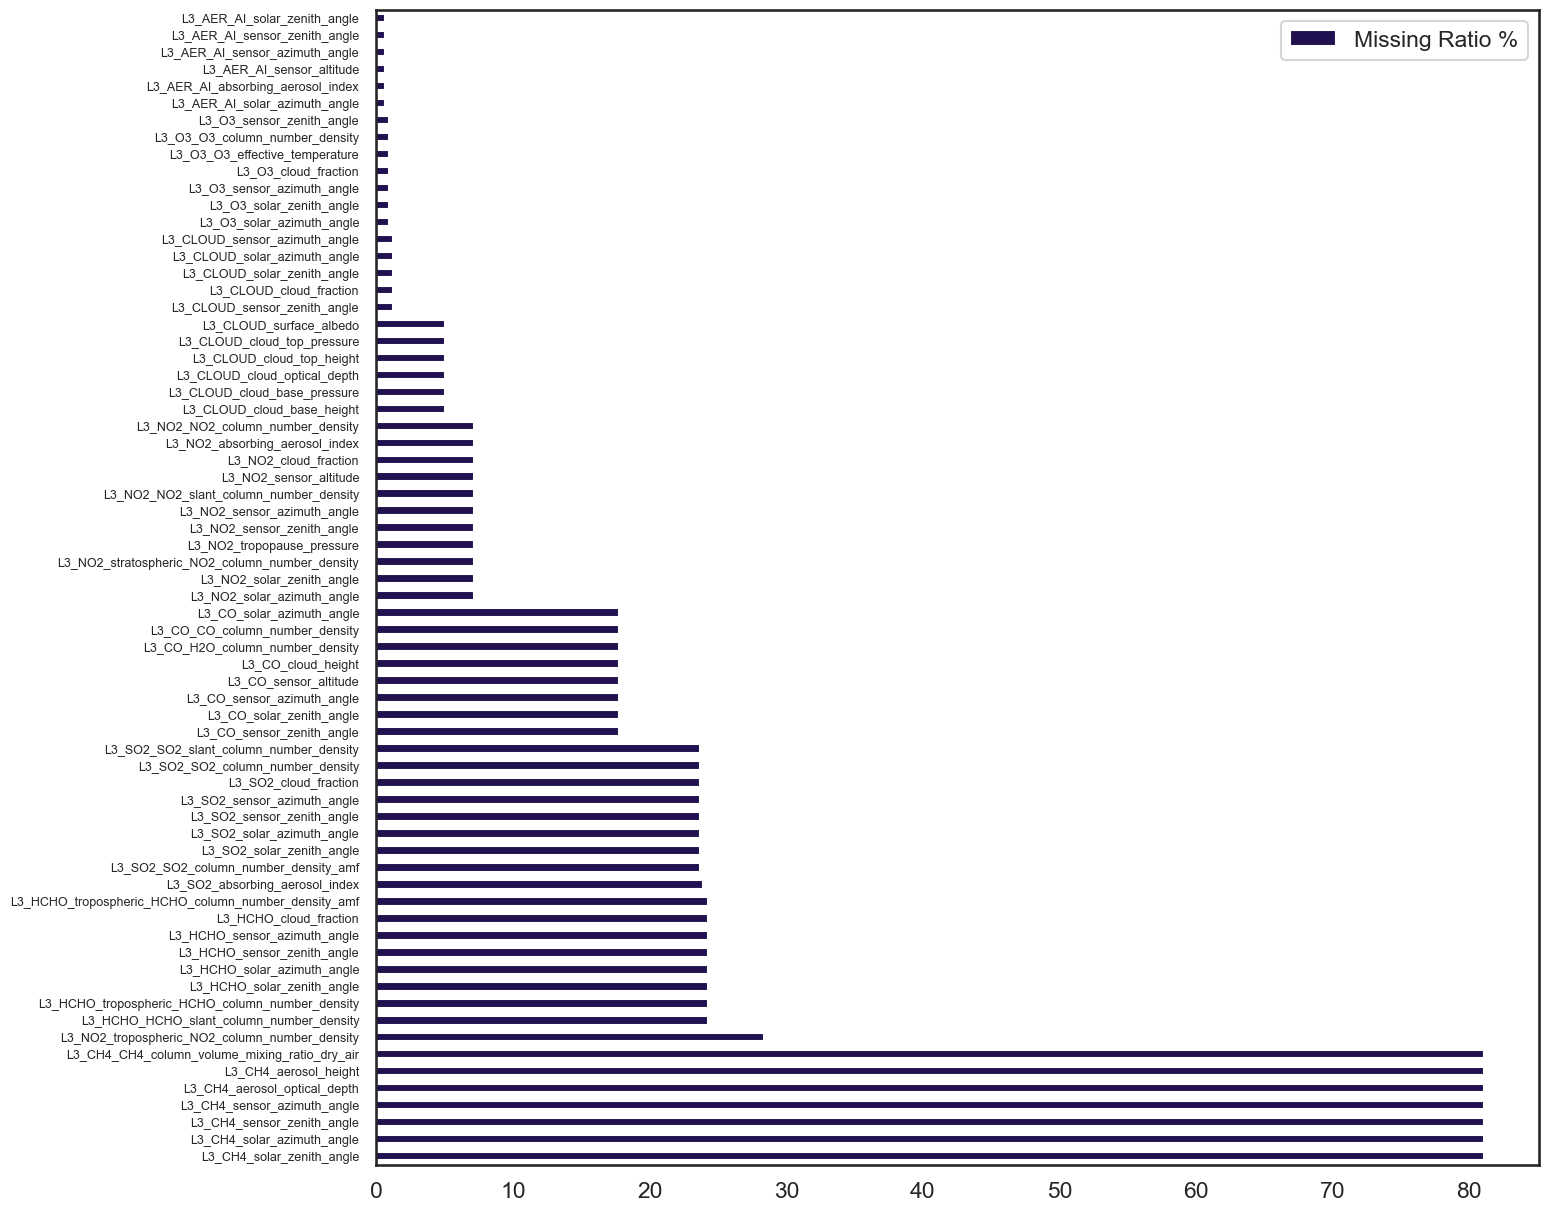

In [ ]:
# plot percentage of missing instances with labels
# from: https://stackoverflow.com/questions/69537383/how-to-plot-count-of-null-values-for-each-column-in-pandas-dataframe
import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)
plot_width, plot_height = (15,15)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
plt.rcParams['ytick.labelsize'] = 9

Looking at the percentages of missing data, we are missing little over 80% data for methane (```CH4```), and up to 25% for formaldehyde (```HCHO```) and sulferdioxide (```SO2```). For carbonmonoxide (```CO```), most nitrogen oxide measurements (```NO2```), cloud (```CLOUD```), ozone (```O3```), and aerosols (```AER```). Given the size of the dataset, we may still be able to include these data in the initial model. However, it may be relevant to look for patterns in the missing satellite data, especially, if this may be meaningful for our business case. Is there a pattern? Is it perhaps weather-related that we can't get satellite measurements? 


# Check balance of the target variable

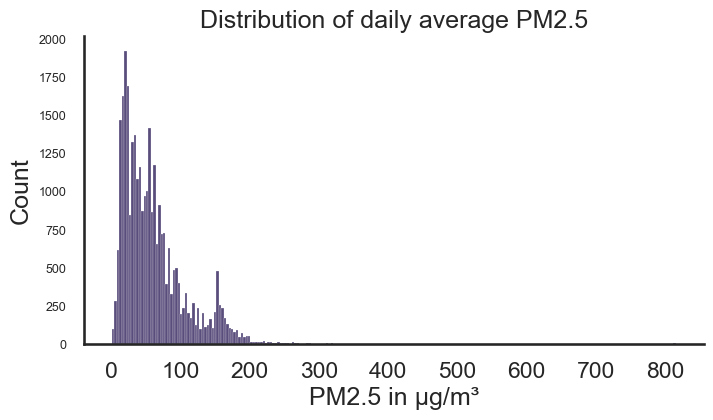

In [172]:
plt.subplots(figsize=(8, 4))
ax = sns.histplot(x=df.target, stat='count', edgecolor='white')
ax.set(xlabel="PM2.5 in µg/m³", title="Distribution of daily average PM2.5")
sns.despine()


In [ ]:
# Create target categories based on https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm25-particles-in-the-air
bins = [0, 12.5, 25, 50, 150, np.inf]
health_cat = ['good', 'fair','poor','very poor','extremely poor']
df['target_cat'] = pd.cut(df['target'], bins, labels = health_cat)

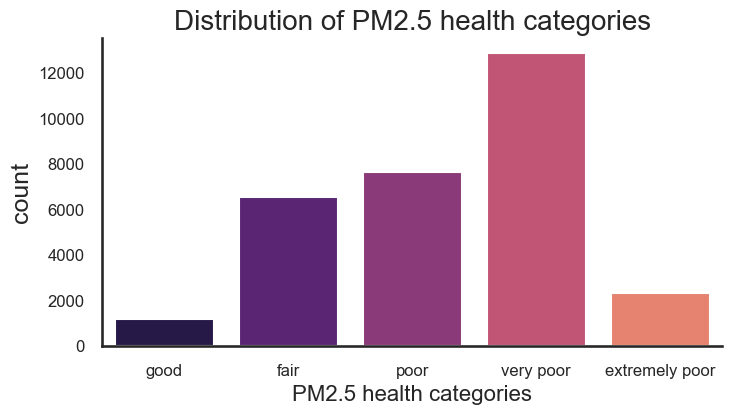

In [173]:
# Check distribution of target categories
plt.subplots(figsize=(8, 4))

ax = sns.countplot(x=df.target_cat)
ax.set_title("Distribution of PM2.5 health categories", fontsize=20)
ax.set_xlabel("PM2.5 health categories", fontsize=16)
ax.tick_params(labelsize=12)

sns.despine()
